# 一、数据处理

In [1]:
import pandas as pd
import numpy as np
train=pd.read_csv(r"E:/ML/logistic/adult.data",header=None,na_values=' ?')
test=pd.read_csv(r"E:/ML/logistic/adult.test",header=None,na_values=' ?')
name=['age','workclass','fnlwgt','education','education_num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country',"income"]
train.columns=name
test.columns=name
train.head()

,age,workclass,fnlwgt,education,education_num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
#删除空值行

test=test.dropna(axis=0)
train=train.dropna(axis=0)

In [4]:
# 选择离散型变量作为分类根据

obj_names=train.dtypes=='object'
obj_names=list(obj_names[obj_names].index)

# 特征名
feature_names=obj_names[:-1]

#训练集和测试集
train_data=train[obj_names]
test_data=test[obj_names]

data_train=np.array(train_data)
data_test=np.array(test_data.drop("income",axis=1))

# 二、决策树算法

In [5]:
# 熵函数
from math import log
def get_entropy(data_set):
    label_count={}
    count=len(data_set)
    
    for label in data_set[:,-1]:
        if label in label_count.keys():
            label_count[label]+=1
        else:
            label_count[label]=1
            
    entropy=0.0
    for key in label_count:
        p=label_count[key]/count
        entropy+=-p*log(p,2)
        
    return entropy

In [6]:
# 根据values分离数据集
def split_data_set(data_set, axis, value):
    """
    :param data_set: 数据集
    :param axis: value的轴
    :param value: value
    :return: 去除axis轴后的数据集
    """
    return_data_set=[]
    for data in data_set:
        if data[axis]==value:
            reduced_data_set = list(data[:axis])
            reduced_data_set.extend(data[axis + 1:])
            return_data_set.append(reduced_data_set)
    return return_data_set

In [7]:
# 选择条件熵最大的特征下标
def choose_best_feature(data_set):
    m,n=data_set.shape
    label_entropy=get_entropy(data_set)
    max_gain=0.0
    max_feature_index=-1
    for i in range(n-1):
        feature=data_set[:,i]
        feature=set(feature)
        feature_entropy=0.0
        
        for feature_value in feature:
            feature_value_set=np.array(split_data_set(data_set,i,feature_value))
            feature_p=len(feature_value_set)/len(data_set)
            feature_entropy+=-feature_p*get_entropy(feature_value_set)
            
        gain=label_entropy-feature_entropy
        if gain>max_gain:
            max_gain=gain
            max_feature_index=i
    return max_feature_index

In [8]:
# 获得最好类别
def get_best_label(data_set):
    label_count={}
    for i in data_set[:,-1]:
        if i not in label_count.keys():
            label_count[i]=0
        label_count[i]+=1
    max_id=-1
    max_label_count=0
    
    for key in label_count:
        if label_count[key]>max_label_count:
            max_id=key
            max_label_count=label_count[key]
    return max_id

In [9]:
# 建立决策树
def create_tree(data_set,names):
    label=set(data_set[:,-1])
    
    #同类输出
    if len(label)==1:
        return label.pop()
    
    #以当前实例数最多的类别作为结果。
    if (len(data_set[0])-1)==1:
        return get_best_label(data_set)
    
    # 选择最好的特征递归生成决策树
    best_feature_id=choose_best_feature(data_set)
    best_feature_value=names[best_feature_id]
    tree={best_feature_value:{}}
    del(names[best_feature_id])
    
    best_feature_set=set(data_set[:,best_feature_id])
    for feature in best_feature_set:
        sub_names=names[:]
        feature_set=split_data_set(data_set,best_feature_id,feature)
        feature_set=np.array(feature_set)
        tree[best_feature_value][feature]=create_tree(feature_set,sub_names)
    return tree

In [10]:
# 对一个样本进行分类
def classify(test_sample,tree,names):
    first_str=list(tree.keys())[0]    #为特征名  或者   label
    second_dict=tree[first_str]       #为特征值
    feature_id=names.index(first_str)
    for value in second_dict:
        if value==test_sample[feature_id]:
            if type(second_dict[value]).__name__=='dict':
                return classify(test_sample,second_dict[value],names)
            else:
                return second_dict[value]
    return 0 # 出现未知特征值

# 对一个测试集进行分类
def test(test_data,tree,names):
    predict=[]
    for data in test_data:
        predict.append(str(classify(data,tree,names)))
    return predict  

In [30]:
# 计算正确率

def get_score(predict,true):
    for i,data in enumerate(true):
        if data==' <=50K.':
            true[i]=0
        else:
            true[i]=1
    for i,data in enumerate(predict):
        if data==' <=50K':
            predict[i]=0
        else:
            predict[i]=1
    length=len(predict)
    yes=0
    for i in range(length):
        if predict[i]==true[i]:
            yes+=1
    return yes/length

# 三、训练与测试

In [91]:
# train
tree=create_tree(data_train,feature_names[:])

In [96]:
# test
true=list(test_data["income"])
predict=test(data_test,tree,feature_names)

In [97]:
# 计算准确率
get_score(predict[:],true[:])

0.7900398406374503

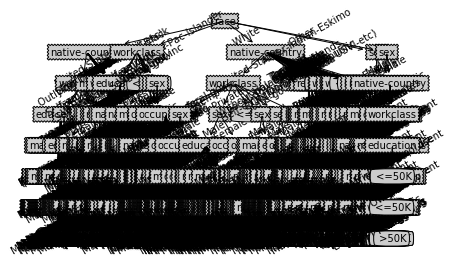

In [14]:
create_plot(tree)

---
# 随机森林

In [12]:
# 生成单独的树
def forest_tree(data_set,names,depth,max_depth):
    label=set(data_set[:,-1])
    if len(label)==1:
        return label.pop()
    if (len(data_set[0])-1)==1:
        return get_best_label(data_set)
    if depth>max_depth:
        return get_best_label(data_set)
    best_feature_id=choose_best_feature(data_set)
    best_feature_value=names[best_feature_id]
    tree={best_feature_value:{}}
    del(names[best_feature_id])
    
    best_feature_set=set(data_set[:,best_feature_id])
    for feature in best_feature_set:
        sub_names=names[:]
        feature_set=split_data_set(data_set,best_feature_id,feature)
        feature_set=np.array(feature_set)
        tree[best_feature_value][feature]=forest_tree(feature_set,sub_names,depth+1,max_depth)
    return tree

In [13]:
# 随机选择数据
def random_data(data_set):
    size=len(data_set)
    new_id=np.random.randint(0,size,size)   
    return data_set[new_id]


In [14]:
#随机森林算法
def random_forest(data_set,test_data,names,number,max_depth):
    forest=[]
    vote=[]
    for i in range(number):
        new_data=random_data(data_set)
        tree=forest_tree(new_data,names[:],0,max_depth)
        forest.append(tree)
    for i in range(number):
        tree_predict=[]
        tree_predict=test(test_data,forest[i],names)
        vote.append(tree_predict)
    return vote,forest


In [15]:
# 通过投票结果预测分类
def vote(forest_predict):
    predict=[]
    tree_number=len(forest_predict)
    sample_size=len(forest_predict[0])
    for i in range(sample_size):
        vote_count={}
        for j in range(tree_number):
            if forest_predict[j][i] not in vote_count.keys():
                vote_count[forest_predict[j][i]]=0
            vote_count[forest_predict[j][i]]+=1
        max_number=0
        vote_result=0
        for key in vote_count:
            if vote_count[key]>max_number:
                max_number=vote_count[key]
                vote_result=key
        predict.append(vote_result)
    return predict

# 训练与测试

In [17]:
# 训练
forest_vote,forest=random_forest(data_train,data_test,feature_names,number=15,max_depth=4)

In [31]:
#获取正确率
forest_predict=vote(forest_vote)
print("随机森林正确率：")
get_score(forest_predict[:],true[:])

随机森林正确率：


0.7733731739707835

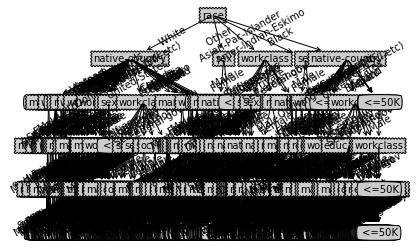

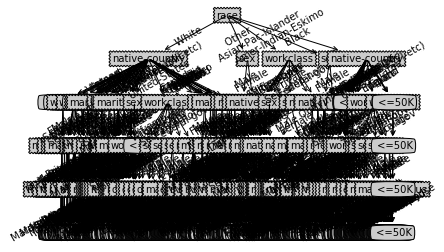

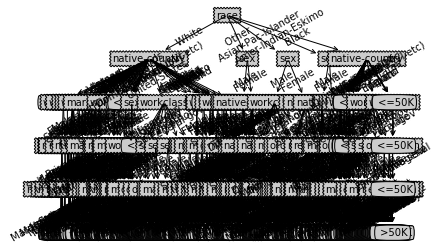

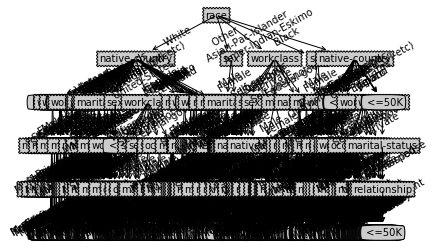

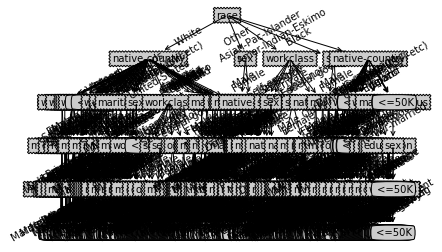

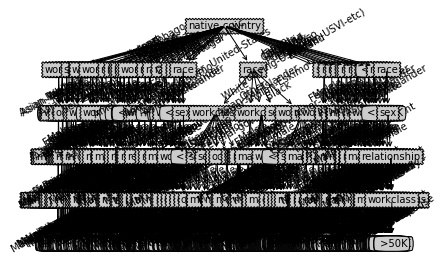

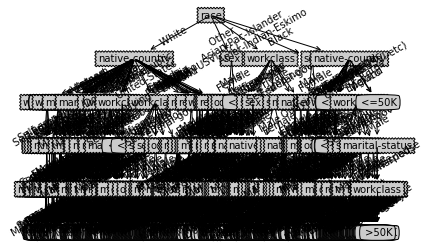

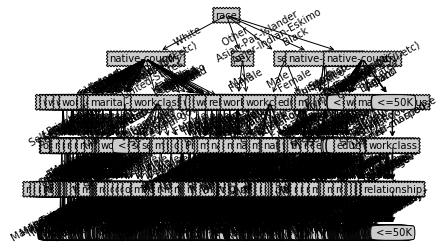

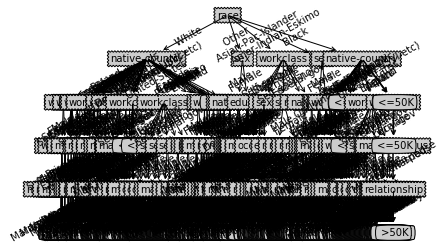

In [ ]:
for i in range(15):
    create_plot(forest[i])

# 绘图函数

In [16]:
import matplotlib.pyplot as plt
 
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")
 
def get_num_leafs(tree):
    num_leafs = 0
    first_str = list(tree.keys())[0]
    second_dict = tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[
                    key]).__name__ == 'dict':  # test to see if the nodes are dictonaires, if not they are leaf nodes
            num_leafs += get_num_leafs(second_dict[key])
        else:
            num_leafs += 1
    return num_leafs
 
def get_tree_depth(tree):
    max_depth = 0
    first_str = list(tree.keys())[0]
    second_dict = tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[
                    key]).__name__ == 'dict':  # test to see if the nodes are dictonaires, if not they are leaf nodes
            this_depth = 1 + get_tree_depth(second_dict[key])
        else:
            this_depth = 1
        if this_depth > max_depth: max_depth = this_depth
    return max_depth
 
def plot_node(node_txt, center_pt, parent_pt, node_type):
    create_plot.ax1.annotate(node_txt, xy=parent_pt, xycoords='axes fraction',
                             xytext=center_pt, textcoords='axes fraction',
                             va="center", ha="center", bbox=node_type, arrowprops=arrow_args)
 
 
def plot_mid_text(center_pt, parent_pt, txt_str):
    x_mid = (parent_pt[0] - center_pt[0]) / 2.0 + center_pt[0]
    y_mid = (parent_pt[1] - center_pt[1]) / 2.0 + center_pt[1]
    create_plot.ax1.text(x_mid, y_mid, txt_str, va="center", ha="center", rotation=30)
 
 
def plot_tree(tree, parent_pt, node_txt):  # if the first key tells you what feat was split on
    num_leafs = get_num_leafs(tree)  # this determines the x width of this tree
    depth = get_tree_depth(tree)
    first_str = list(tree.keys())[0]  # the text label for this node should be this
    cntr_pt = (plot_tree.xOff + (1.0 + float(num_leafs)) / 2.0 / plot_tree.totalW, plot_tree.yOff)
    plot_mid_text(cntr_pt, parent_pt, node_txt)
    plot_node(first_str, cntr_pt, parent_pt, decisionNode)
    second_dict = tree[first_str]
    plot_tree.yOff = plot_tree.yOff - 1.0 / plot_tree.totalD
    for key in second_dict.keys():
        if type(second_dict[
                    key]).__name__ == 'dict':  # test to see if the nodes are dictonaires, if not they are leaf nodes
            plot_tree(second_dict[key], cntr_pt, str(key))  # recursion
        else:  # it's a leaf node print the leaf node
            plot_tree.xOff = plot_tree.xOff + 1.0 / plot_tree.totalW
            plot_node(second_dict[key], (plot_tree.xOff, plot_tree.yOff), cntr_pt, leafNode)
            plot_mid_text((plot_tree.xOff, plot_tree.yOff), cntr_pt, str(key))
    plot_tree.yOff = plot_tree.yOff + 1.0 / plot_tree.totalD
 
 
def create_plot(tree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)  # no ticks
    # createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses
    plot_tree.totalW = float(get_num_leafs(tree))
    plot_tree.totalD = float(get_tree_depth(tree))
    plot_tree.xOff = -0.5 / plot_tree.totalW;
    plot_tree.yOff = 1.0;
    plot_tree(tree, (0.5, 1.0), '')
    plt.show()
 